In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import os
import pickle
import sys
from scipy import sparse
from pandas.api.types import CategoricalDtype

# show all columns and all column content
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

pool_names = ['BTC/USDC', 'ETH/USDC', 'YFI/USDC', 'DOT/USDC', 'SNX/USDC',
            'LINK/USDC', 'AAVE/USDC', 'SUSHI/USDC', 'COMP/USDC', 'REN/USDC',
            'PERP/USDC', 'UNI/USDC', 'CRV/USDC', 'MKR/USDC', 'CREAM/USDC',
            'GRT/USDC', 'ALPHA/USDC', 'FTT/USDC']


In [3]:
def hued_lineplot(df: pd.DataFrame, column_1: str, column_2: str, hued_column: str,
                  labels: list, xlabel: str, ylabel: str, title: str, 
                  color_set: str='Set1', xsize: int=30, ysize: int=15,
                  is_grid_required: bool=False):
    """Hued lineplot

    Args:
        df (pd.DataFrame): data to plot
        column_1 (str): x axis column
        column_2 (str): y axis column
        hued_column (str): column based on which hue will be performed
        labels (list): categories based on which hue will be done
        xlabel (str): x axis name
        ylabel (str): y axis name
        title (str): name of the chart
        color_set (str, optional): color set chosen for plotting lines. Defaults to 'Set1'.
        xsize (int, optional): x size of chart. Defaults to 30.
        ysize (int, optional): y size of chart. Defaults to 15.
        is_grid_required (bool, optional): is grid of the chart required. Defaults to False
    """
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    rgb_values = sns.color_palette(color_set, len(labels))
    color_map = dict(zip(labels, rgb_values))
    
    for label in labels:
        ax.plot(df[df[hued_column] == label][column_1], df[df[hued_column] == label][column_2],
                color=color_map[label], label=label)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.grid(is_grid_required)
    plt.show()

In [4]:
overall_history_list = []
for amm_name in pool_names:
    amm_history = pd.read_csv('' + amm_name.split('/')[0].lower() + '_usdc_indexed_position.csv')
    print('amm ' + amm_name + ' has ' + str(len(amm_history[(amm_history['position_size_after'] == 0) &
                                                           (amm_history['exchanged_position_size'] != 0)])) + 
                                                ' closes')
    
    overall_history_list.append(amm_history)
    
opens_closes_positions_df = pd.concat(overall_history_list)
opens_closes_positions_df['timestamp'] = pd.to_datetime(opens_closes_positions_df['timestamp'])

amm BTC/USDC has 34253 closes
amm ETH/USDC has 44866 closes
amm YFI/USDC has 64003 closes
amm DOT/USDC has 82901 closes
amm SNX/USDC has 94867 closes
amm LINK/USDC has 65534 closes
amm AAVE/USDC has 78000 closes
amm SUSHI/USDC has 94437 closes
amm COMP/USDC has 72679 closes
amm REN/USDC has 89550 closes
amm PERP/USDC has 83685 closes
amm UNI/USDC has 55174 closes
amm CRV/USDC has 93346 closes
amm MKR/USDC has 47335 closes
amm CREAM/USDC has 61454 closes
amm GRT/USDC has 72325 closes
amm ALPHA/USDC has 56656 closes
amm FTT/USDC has 39502 closes


# Trader analysis

In [5]:
amm_trader_list = []

for amm in opens_closes_positions_df['amm_name'].unique():
    amm_story = opens_closes_positions_df[opens_closes_positions_df['amm_name'] == amm]
    amm_trader_df = pd.DataFrame(columns=['amm', 'trader'])
    amm_trader_df['trader'] = amm_story['trader'].unique()
    amm_trader_df['amm'] = [amm] * len(amm_story['trader'].unique())
    amm_trader_list.append(amm_trader_df)
    
traders_amm_df = pd.concat(amm_trader_list)
traders_amm_df["count"] = [1] * len(traders_amm_df)
traders_amm_df

amm                                      trader  count
0    BTC/USDC  0x1a48776f436bcdaa16845a378666cf4ba131eb0f      1
1    BTC/USDC  0x9602686bf53a17baed60c48ba34ed4219a532381      1
2    BTC/USDC  0x43bd90e4cc93d6e40580507102cc7b1bc8a25284      1
3    BTC/USDC  0x5bea7caa02142ba59885466757e1112819731f09      1
4    BTC/USDC  0x069a67b8f965d02d095be12ae55e31e769692df4      1
..        ...                                         ...    ...
561  FTT/USDC  0xc0f872a7127bdc6d98af04899d1a1d22376c7b6b      1
562  FTT/USDC  0x419df1d41f84de3d3854a4e6d0b4d772ebd1b13b      1
563  FTT/USDC  0xb39885f302643a5f96f743c3621d628dc3f72ce6      1
564  FTT/USDC  0xa84daa76815f6d2cf99e406bd693e8588bc36dbe      1
565  FTT/USDC  0xfe8b307829c386bc056e43fa2f4a9edc7a7a62ca      1

[18245 rows x 3 columns]

In [6]:
users = traders_amm_df["trader"].unique()
amms = traders_amm_df["amm"].unique()
shape = (len(users), len(amms))

user_cat = CategoricalDtype(categories=sorted(users), ordered=True)
amms_cat = CategoricalDtype(categories=sorted(amms), ordered=True)

user_index = traders_amm_df["trader"].astype(user_cat).cat.codes
amm_index = traders_amm_df["amm"].astype(amms_cat).cat.codes

# Conversion via COO matrix
coo = sparse.coo_matrix((traders_amm_df["count"], (user_index, amm_index)), shape=shape)
csr = coo.tocsr()

In [7]:
csr.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 0, 1]], dtype=int64)

In [8]:
traders_amm_df[traders_amm_df["trader"] == "0xffff0c6febddbab590ad077096d87ce806aace47"]['amm'].unique()

array(['BTC/USDC', 'ETH/USDC', 'YFI/USDC', 'AAVE/USDC'], dtype=object)

In [9]:
stats_df = pd.DataFrame.sparse.from_spmatrix(csr, columns=amms_cat.categories)
stats_df.index = user_cat.categories
stats_df['occurencies_sum'] = stats_df.sum(axis=1)
stats_df

AAVE/USDC  ALPHA/USDC  BTC/USDC  \
0x000000003b0371b33aba8b6b58154a98d54695ad          0           0         0   
0x000000064730640b7d670408d74280924883064f          0           0         0   
0x0000000813b34008a225de08a6a61835508c71f9          0           0         1   
0x000000ea89990a17ec07a35ac2bbb02214c50152          1           0         1   
0x0000ce08fa224696a819877070bf378e8b131acf          0           0         0   
...                                               ...         ...       ...   
0xffe694afb3b54ee0add6ded4cc0f9917777f13da          0           0         0   
0xfffb40347816873ca038756cc87bc610144166b2          0           0         0   
0xfffdd2572f57b6457c8c4b0320e8f1f1ec4812bd          0           0         0   
0xfffe45d946f1f715dc0252df3db22a9edfaf5738          0           0         0   
0xffff0c6febddbab590ad077096d87ce806aace47          1           0         1   

                                            COMP/USDC  CREAM/USDC  CRV/USDC  \
0x000000003b0371b33aba8b6b58154a98d54695ad          0           0         0   
0x000000064730640b7d670408d74280924883064f          0           0         0   
0x0000000813b34008a225de08a6a61835508c71f9          0           0         0   
0x000000ea89990a17ec07a35ac2bbb02214c50152          1           1         1   
0x0000ce08fa224696a819877070bf378e8b131acf          0           0         1   
...                                               ...         ...       ...   
0xffe694afb3b54ee0add6ded4cc0f9917777f13da          0           0         0   
0xfffb40347816873ca038756cc87bc610144166b2          0           0         0   
0xfffdd2572f57b6457c8c4b0320e8f1f1ec4812bd          0           0         0   
0xfffe45d946f1f715dc0252df3db22a9edfaf5738          0           0         0   
0xffff0c6febddbab590ad077096d87ce806aace47          0           0         0   

                                            DOT/USDC  ETH/USDC  FTT/USDC  \
0x000000003b0371b33aba8b6b58154a98d54695ad         0         0         0   
0x000000064730640b7d670408d74280924883064f         0         1         0   
0x0000000813b34008a225de08a6a61835508c71f9         0         0         0   
0x000000ea89990a17ec07a35ac2bbb02214c50152         1         1         1   
0x0000ce08fa224696a819877070bf378e8b131acf         0         1         0   
...                                              ...       ...       ...   
0xffe694afb3b54ee0add6ded4cc0f9917777f13da         0         0         0   
0xfffb40347816873ca038756cc87bc610144166b2         0         1         0   
0xfffdd2572f57b6457c8c4b0320e8f1f1ec4812bd         0         1         0   
0xfffe45d946f1f715dc0252df3db22a9edfaf5738         0         0         0   
0xffff0c6febddbab590ad077096d87ce806aace47         0         1         0   

                                            GRT/USDC  LINK/USDC  MKR/USDC  \
0x000000003b0371b33aba8b6b58154a98d54695ad         0          0         0   
0x000000064730640b7d670408d74280924883064f         0          0         0   
0x0000000813b34008a225de08a6a61835508c71f9         0          0         0   
0x000000ea89990a17ec07a35ac2bbb02214c50152         1          1         1   
0x0000ce08fa224696a819877070bf378e8b131acf         0          0         0   
...                                              ...        ...       ...   
0xffe694afb3b54ee0add6ded4cc0f9917777f13da         0          0         1   
0xfffb40347816873ca038756cc87bc610144166b2         0          0         0   
0xfffdd2572f57b6457c8c4b0320e8f1f1ec4812bd         0          0         0   
0xfffe45d946f1f715dc0252df3db22a9edfaf5738         0          0         0   
0xffff0c6febddbab590ad077096d87ce806aace47         0          0         0   

                                            PERP/USDC  REN/USDC  SNX/USDC  \
0x000000003b0371b33aba8b6b58154a98d54695ad          1         0         0   
0x000000064730640b7d670408d74280924883064f          0         0         0   
0x0000000813b34008a225de08a6a61835508c71f9          0         0         0   


In [10]:
print(stats_df['ALPHA/USDC'].sum())

572


In [11]:
unique_traders_for_amm_df = pd.DataFrame()
for amm in traders_amm_df['amm'].unique():
    new_record = {"amm": amm, "unique_traders_for_amm": stats_df[stats_df['occurencies_sum'] == 1][amm].sum()}
    unique_traders_for_amm_df = unique_traders_for_amm_df.append(new_record, ignore_index=True)
    
unique_traders_for_amm_df

amm  unique_traders_for_amm
0     BTC/USDC                  3850.0
1     ETH/USDC                  2796.0
2     YFI/USDC                    75.0
3     DOT/USDC                   103.0
4     SNX/USDC                    37.0
5    LINK/USDC                   284.0
6    AAVE/USDC                    50.0
7   SUSHI/USDC                    70.0
8    COMP/USDC                    19.0
9     REN/USDC                    19.0
10   PERP/USDC                   257.0
11    UNI/USDC                    57.0
12    CRV/USDC                   214.0
13    MKR/USDC                    23.0
14  CREAM/USDC                    18.0
15    GRT/USDC                    30.0
16  ALPHA/USDC                   214.0
17    FTT/USDC                   169.0

In [12]:
up_to_5_amm_traders_df = pd.DataFrame()
for amm in traders_amm_df['amm'].unique():
    new_record = {"amm": amm, "up_to_5_amm_traders": stats_df[(stats_df['occurencies_sum'] > 1) &
                                                              (stats_df['occurencies_sum'] < 6)][amm].sum()}
    up_to_5_amm_traders_df = up_to_5_amm_traders_df.append(new_record, ignore_index=True)
    
up_to_5_amm_traders_df

amm  up_to_5_amm_traders
0     BTC/USDC                750.0
1     ETH/USDC                859.0
2     YFI/USDC                122.0
3     DOT/USDC                226.0
4     SNX/USDC                117.0
5    LINK/USDC                173.0
6    AAVE/USDC                126.0
7   SUSHI/USDC                186.0
8    COMP/USDC                 72.0
9     REN/USDC                 73.0
10   PERP/USDC                304.0
11    UNI/USDC                 93.0
12    CRV/USDC                131.0
13    MKR/USDC                 47.0
14  CREAM/USDC                 83.0
15    GRT/USDC                 56.0
16  ALPHA/USDC                 75.0
17    FTT/USDC                125.0

In [13]:
up_to_15_amm_traders_df = pd.DataFrame()
for amm in traders_amm_df['amm'].unique():
    new_record = {"amm": amm, "up_to_15_amm_traders": stats_df[(stats_df['occurencies_sum'] > 5) &
                                                              (stats_df['occurencies_sum'] < 16)][amm].sum()}
    up_to_15_amm_traders_df = up_to_15_amm_traders_df.append(new_record, ignore_index=True)
    
up_to_15_amm_traders_df

amm  up_to_15_amm_traders
0     BTC/USDC                 338.0
1     ETH/USDC                 410.0
2     YFI/USDC                 248.0
3     DOT/USDC                 349.0
4     SNX/USDC                 287.0
5    LINK/USDC                 295.0
6    AAVE/USDC                 296.0
7   SUSHI/USDC                 357.0
8    COMP/USDC                 217.0
9     REN/USDC                 216.0
10   PERP/USDC                 308.0
11    UNI/USDC                 253.0
12    CRV/USDC                 281.0
13    MKR/USDC                 172.0
14  CREAM/USDC                 157.0
15    GRT/USDC                 182.0
16  ALPHA/USDC                 194.0
17    FTT/USDC                 188.0

In [14]:
up_to_18_amm_traders_df = pd.DataFrame()
for amm in traders_amm_df['amm'].unique():
    new_record = {"amm": amm, "up_to_18_amm_traders": stats_df[(stats_df['occurencies_sum'] > 15) &
                                                              (stats_df['occurencies_sum'] < 19)][amm].sum()}
    up_to_18_amm_traders_df = up_to_18_amm_traders_df.append(new_record, ignore_index=True)
    
up_to_18_amm_traders_df

amm  up_to_18_amm_traders
0     BTC/USDC                  85.0
1     ETH/USDC                  89.0
2     YFI/USDC                  86.0
3     DOT/USDC                  91.0
4     SNX/USDC                  90.0
5    LINK/USDC                  90.0
6    AAVE/USDC                  88.0
7   SUSHI/USDC                  90.0
8    COMP/USDC                  90.0
9     REN/USDC                  88.0
10   PERP/USDC                  90.0
11    UNI/USDC                  88.0
12    CRV/USDC                  91.0
13    MKR/USDC                  85.0
14  CREAM/USDC                  89.0
15    GRT/USDC                  91.0
16  ALPHA/USDC                  89.0
17    FTT/USDC                  84.0

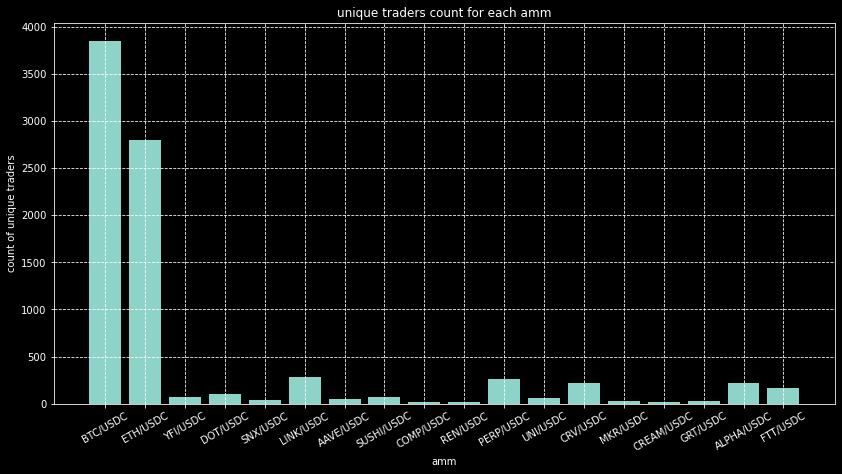

In [15]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(unique_traders_for_amm_df['amm'], unique_traders_for_amm_df['unique_traders_for_amm'])
ax.set_xlabel('amm')
ax.set_ylabel('count of unique traders')
ax.set_title('unique traders count for each amm')
ax.grid(True, linestyle='--')
plt.xticks(rotation=30)
plt.show()

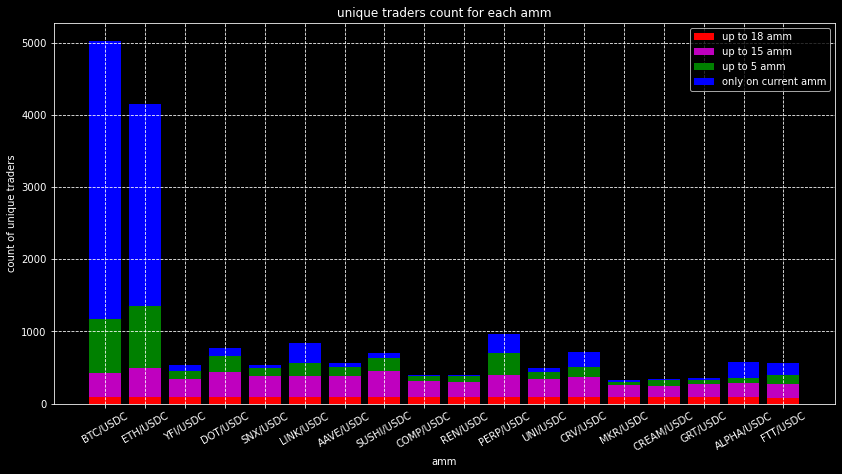

In [16]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(up_to_18_amm_traders_df['amm'], up_to_18_amm_traders_df['up_to_18_amm_traders'], color='r', label='up to 18 amm')
ax.bar(up_to_15_amm_traders_df['amm'], up_to_15_amm_traders_df['up_to_15_amm_traders'], color='m', label='up to 15 amm',
       bottom=up_to_18_amm_traders_df['up_to_18_amm_traders'])
ax.bar(up_to_5_amm_traders_df['amm'], up_to_5_amm_traders_df['up_to_5_amm_traders'], color='g', label='up to 5 amm',
       bottom=up_to_18_amm_traders_df['up_to_18_amm_traders'] + up_to_15_amm_traders_df['up_to_15_amm_traders'])
ax.bar(unique_traders_for_amm_df['amm'], unique_traders_for_amm_df['unique_traders_for_amm'], color='b', label='only on current amm',
      bottom=up_to_18_amm_traders_df['up_to_18_amm_traders'] + up_to_15_amm_traders_df['up_to_15_amm_traders'] + up_to_5_amm_traders_df['up_to_5_amm_traders'])
ax.set_xlabel('amm')
ax.set_ylabel('count of unique traders')
ax.set_title('unique traders count for each amm')
ax.grid(True, linestyle='--')
ax.legend()
plt.xticks(rotation=30)
plt.show()

# Possible bots analysis: bots that work on entire system

In [17]:
big_pools = ['BTC/USDC', 'YFI/USDC']
medium_pools = ['ETH/USDC', 'MKR/USDC', 'COMP/USDC', 'AAVE/USDC']
small_pools = ['DOT/USDC', 'SNX/USDC', 'LINK/USDC',  'SUSHI/USDC', 
               'REN/USDC', 'PERP/USDC', 'UNI/USDC', 'CRV/USDC', 
               'GRT/USDC', 'ALPHA/USDC', 'unknown', 'FTT/USDC', 'CREAM/USDC']

In [18]:
entire_perpetual_traders_df = stats_df[stats_df['occurencies_sum'] == 18]
bots_positions_df = opens_closes_positions_df[opens_closes_positions_df['trader'].isin(entire_perpetual_traders_df.index)]

In [19]:
bots_positions_df

Unnamed: 0  \
0                0   
1                3   
2                4   
3               34   
4               51   
...            ...   
301788     8457930   
301789     8458013   
301790     8458023   
301791     8491586   
301792     8491600   

                                                                           id  \
0       0x06d54c4ad4bfff493051ef548557f4fa0c76fb2dd6787fd665f3b9bf001ad88e-20   
1        0xe9d804889de5a27a356777a588d6c018e55fa1cae61c6265f11595c4c293a697-6   
2        0xea81e16520eae51395b4627365487daa2013df876ef3e38254579d1d149b17fd-6   
3        0xcbc30cda2cff5814702d67c67530f6598a670ad990f3875e8e314c564279df13-6   
4        0xb7f635c0407feb60d7386e18b0d102503e5c9f034be9791bd961f75d22aceb69-6   
...                                                                       ...   
301788  0xf8f0aa46df36528c06fbde647fd41bc762d3f77e061384d0d17fac89f499a25b-20   
301789   0xbc3bf30cc9ca5da1e08cc3a2b67b8f630dbe009a5b7cbc82db64bcf7a946e3d9-9   
301790  0x651fd60d346e2807c2611d605fc02be395296c37c281ca0cd513eac06e0c1e54-10   
301791  0xf413f0d98bdfc354bce48bddc6d835a5c1f0ce3db07dcea926a1920516157a44-19   
301792   0xa5e241c6d438f5d788b250eacbcd89c894f00a47510d792c103a4f2d667f6385-5   

                                            trader  \
0       0x1a48776f436bcdaa16845a378666cf4ba131eb0f   
1       0x1a48776f436bcdaa16845a378666cf4ba131eb0f   
2       0x1a48776f436bcdaa16845a378666cf4ba131eb0f   
3       0x1a48776f436bcdaa16845a378666cf4ba131eb0f   
4       0x1a48776f436bcdaa16845a378666cf4ba131eb0f   
...                                            ...   
301788  0x884721e14f325b5861da34115b5262df0485d738   
301789  0x884721e14f325b5861da34115b5262df0485d738   
301790  0x884721e14f325b5861da34115b5262df0485d738   
301791  0x884721e14f325b5861da34115b5262df0485d738   
301792  0x884721e14f325b5861da34115b5262df0485d738   

                                               amm        margin  \
0       0x0f346e19f01471c02485df1758cfd3d624e399b4   5552.445854   
1       0x0f346e19f01471c02485df1758cfd3d624e399b4  11114.600000   
2       0x0f346e19f01471c02485df1758cfd3d624e399b4      0.000000   
3       0x0f346e19f01471c02485df1758cfd3d624e399b4   5555.467426   
4       0x0f346e19f01471c02485df1758cfd3d624e399b4  11123.834606   
...                                            ...           ...   
301788  0x838b322610bd99a449091d3bf3fba60d794909a9   1015.063347   
301789  0x838b322610bd99a449091d3bf3fba60d794909a9   1017.290953   
301790  0x838b322610bd99a449091d3bf3fba60d794909a9      0.000000   
301791  0x838b322610bd99a449091d3bf3fba60d794909a9   1003.798178   
301792  0x838b322610bd99a449091d3bf3fba60d794909a9      0.000000   

        position_notional  exchanged_position_size        fee  \
0            16657.337561                 0.872710  16.657338   
1            16686.462439                 0.871187  16.686462   
2            33343.800000                -1.743896  33.343800   
3            16666.402278                 0.872235  16.666402   
4            16703.914119                 0.870276  16.703914   
...                   ...                      ...        ...   
301788        3045.190040               -80.649102   3.045190   
301789        2031.270186                53.861489   2.031270   
301790        1010.584364                26.787613   1.010584   
301791        3011.394535               -79.990466   3.011395   
301792        3009.011988                79.990466   3.009012   

        position_size_after  realized_pnl  unrealized_pnl_after  bad_debt  \
0                  0.872710  0.000000e+00              0.000000       0.0   
1                  1.743896  0.000000e+00             58.249669       0.0   
2                  0.000000 -1.782200e-14              0.000000       0.0   
3                  0.872235  0.000000e+00              0.000000       0.0   
4                  1.742512  0.000000e+00             75.042344       0.0   
...                     ...           ...                   .

In [20]:
bots_positions_df.sort_values(by=["timestamp"], inplace=True)

C:\Users\Zbook\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## Margin for BTC/USDC

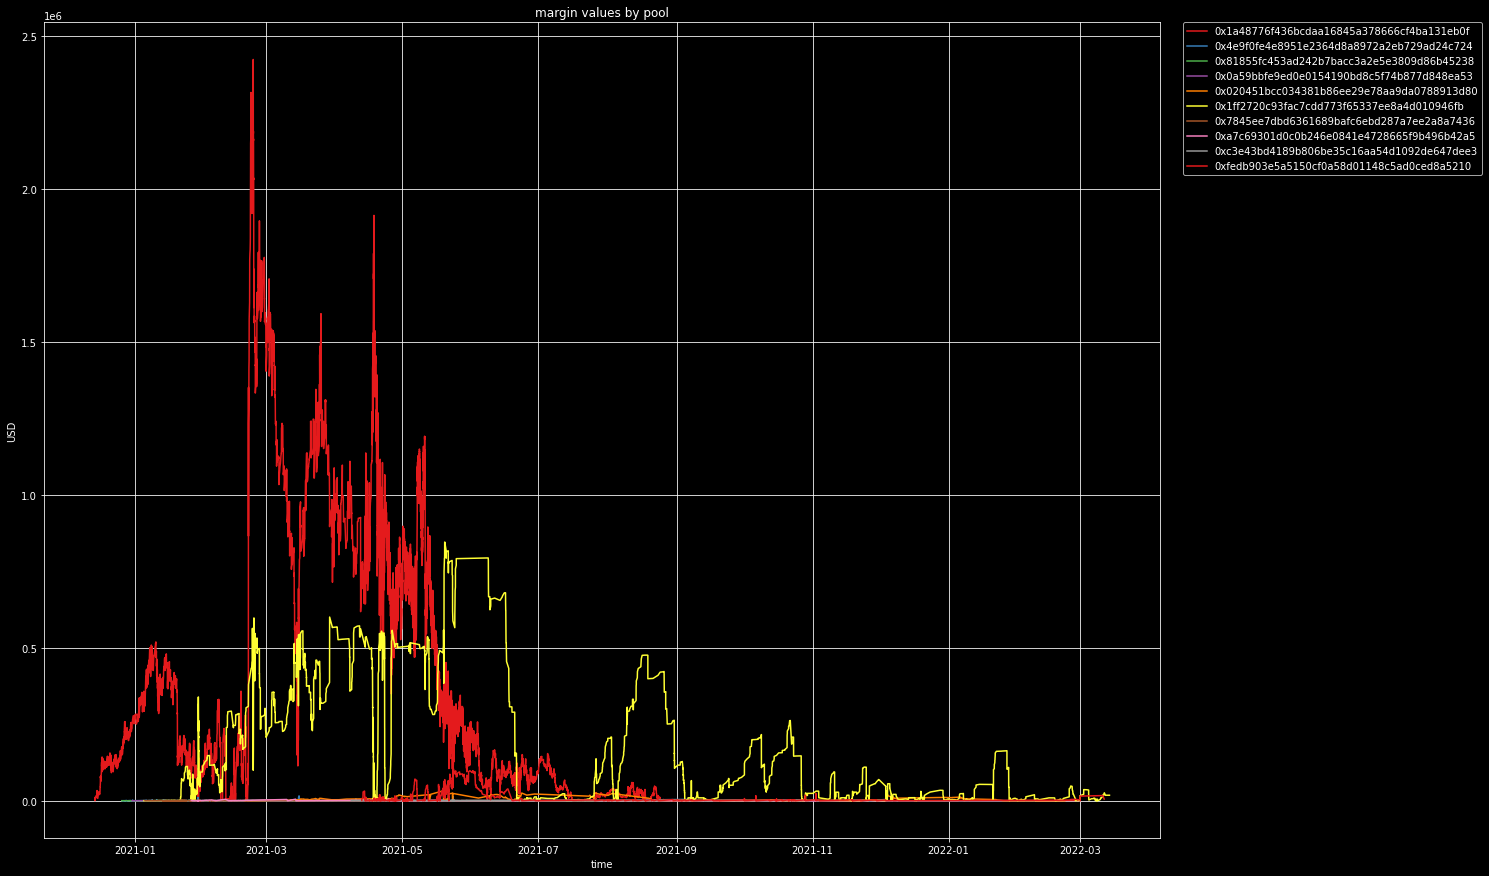

In [21]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[:10],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

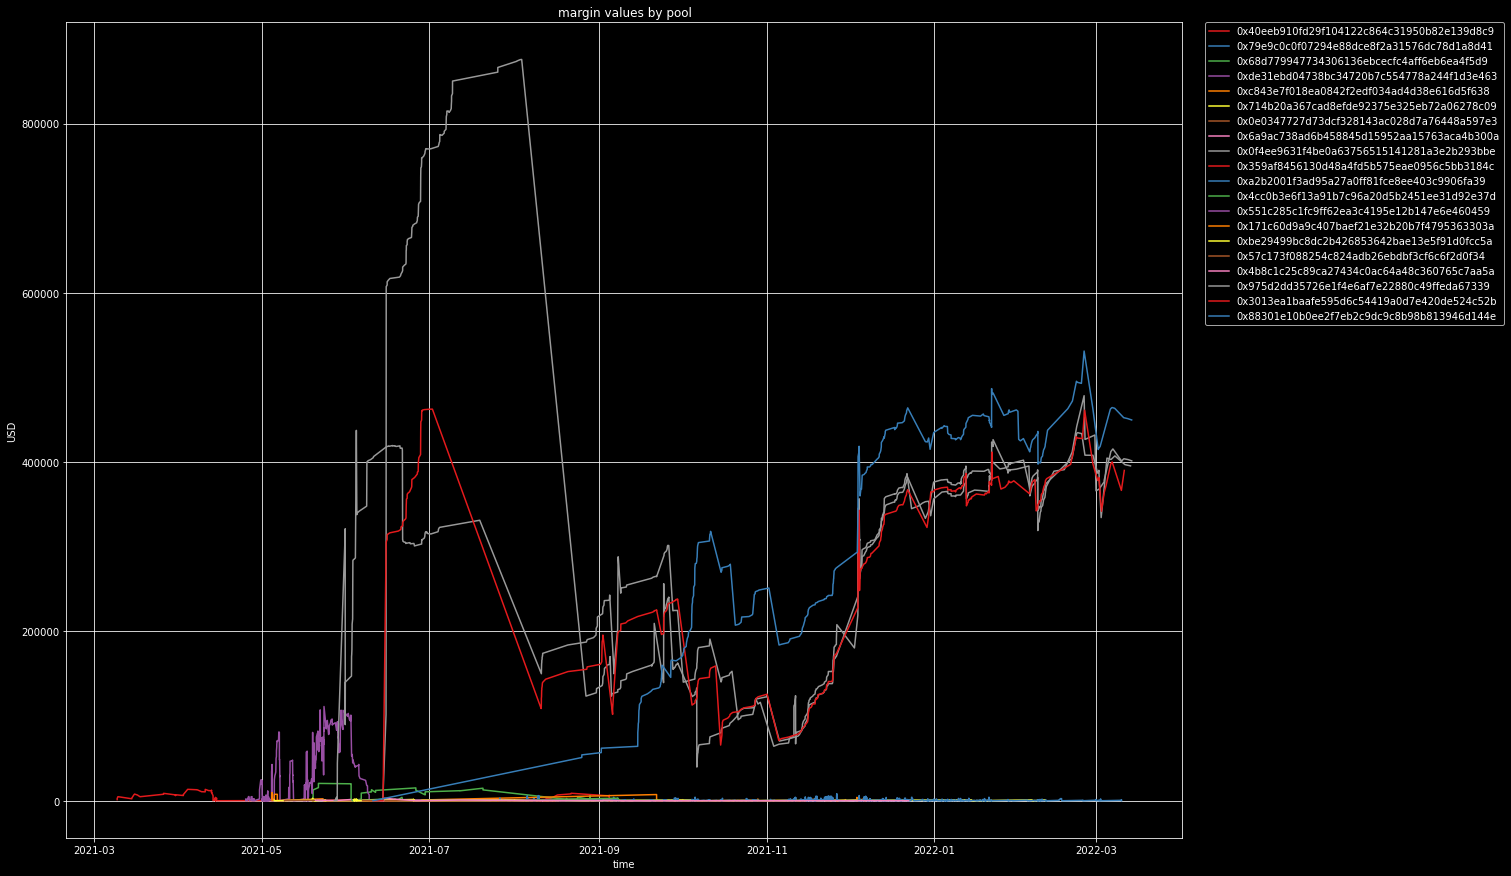

In [22]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[10:30],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

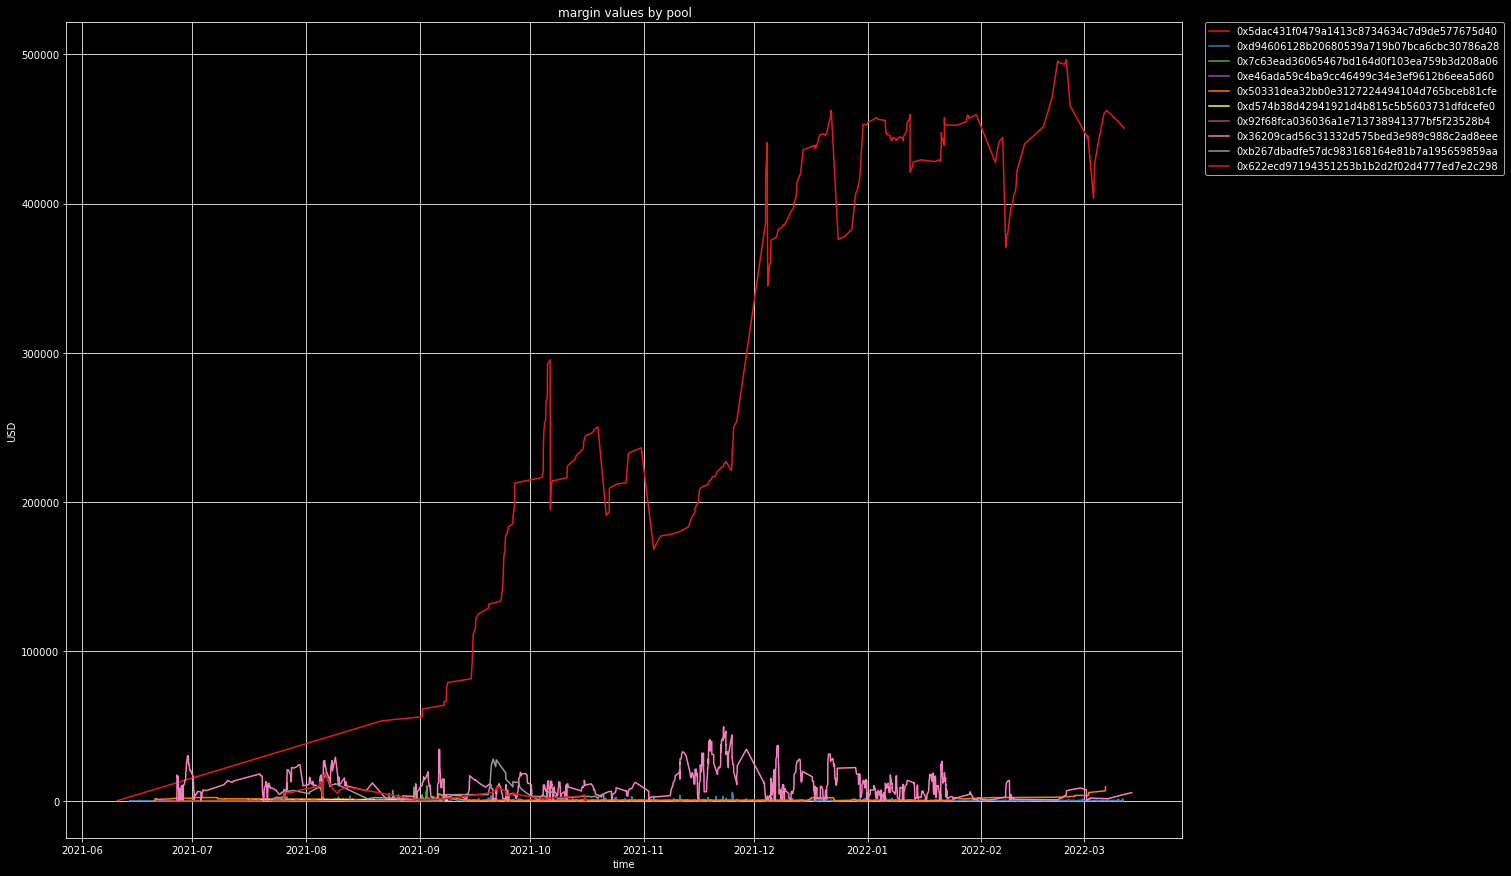

In [23]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[30:40],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

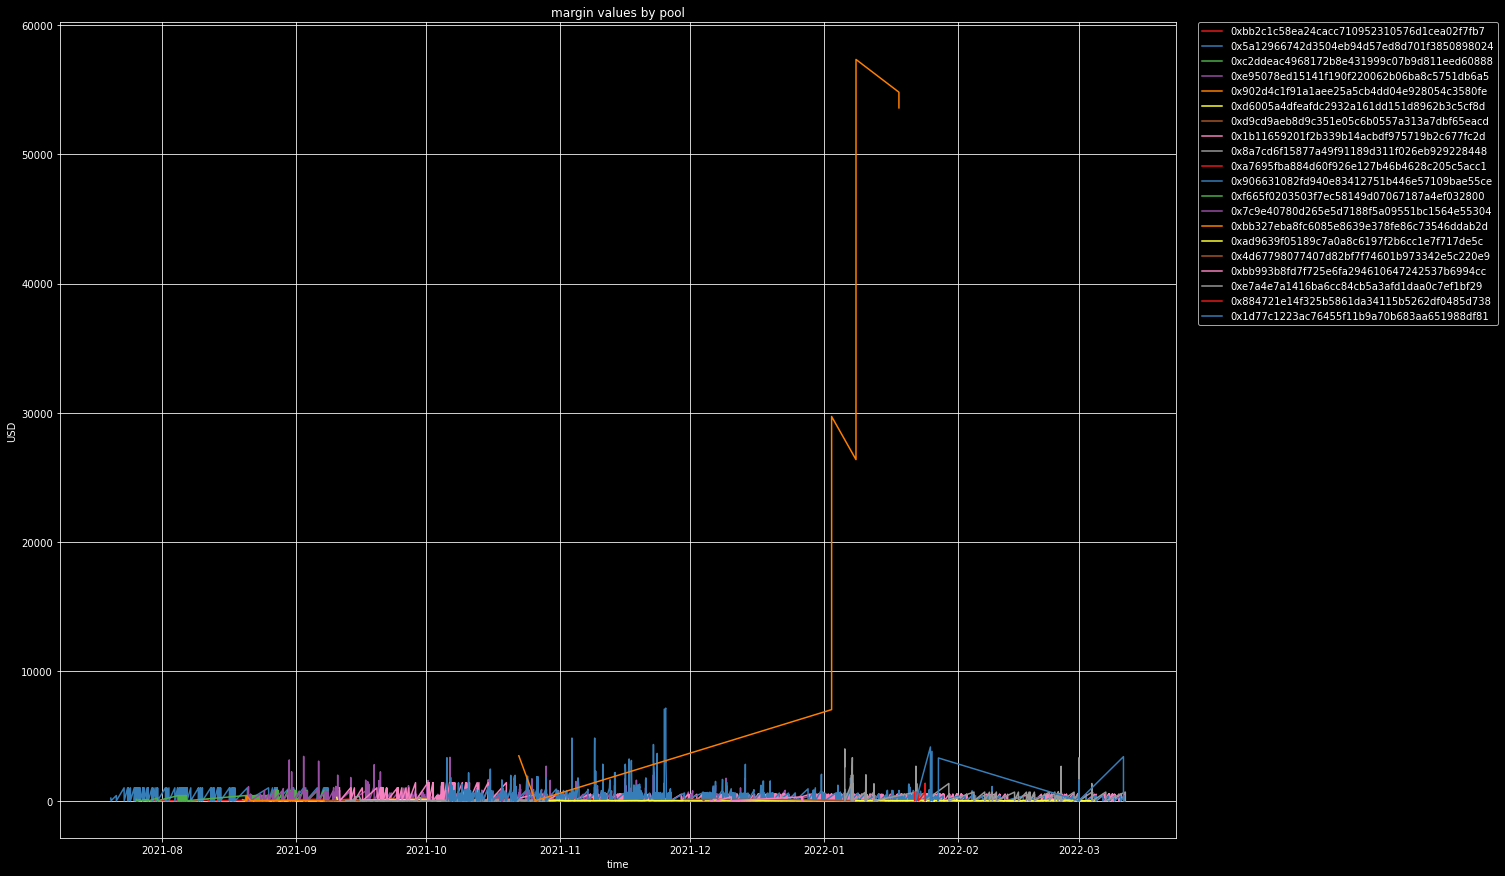

In [24]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[40:60],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

## Margin for ETH/USDC

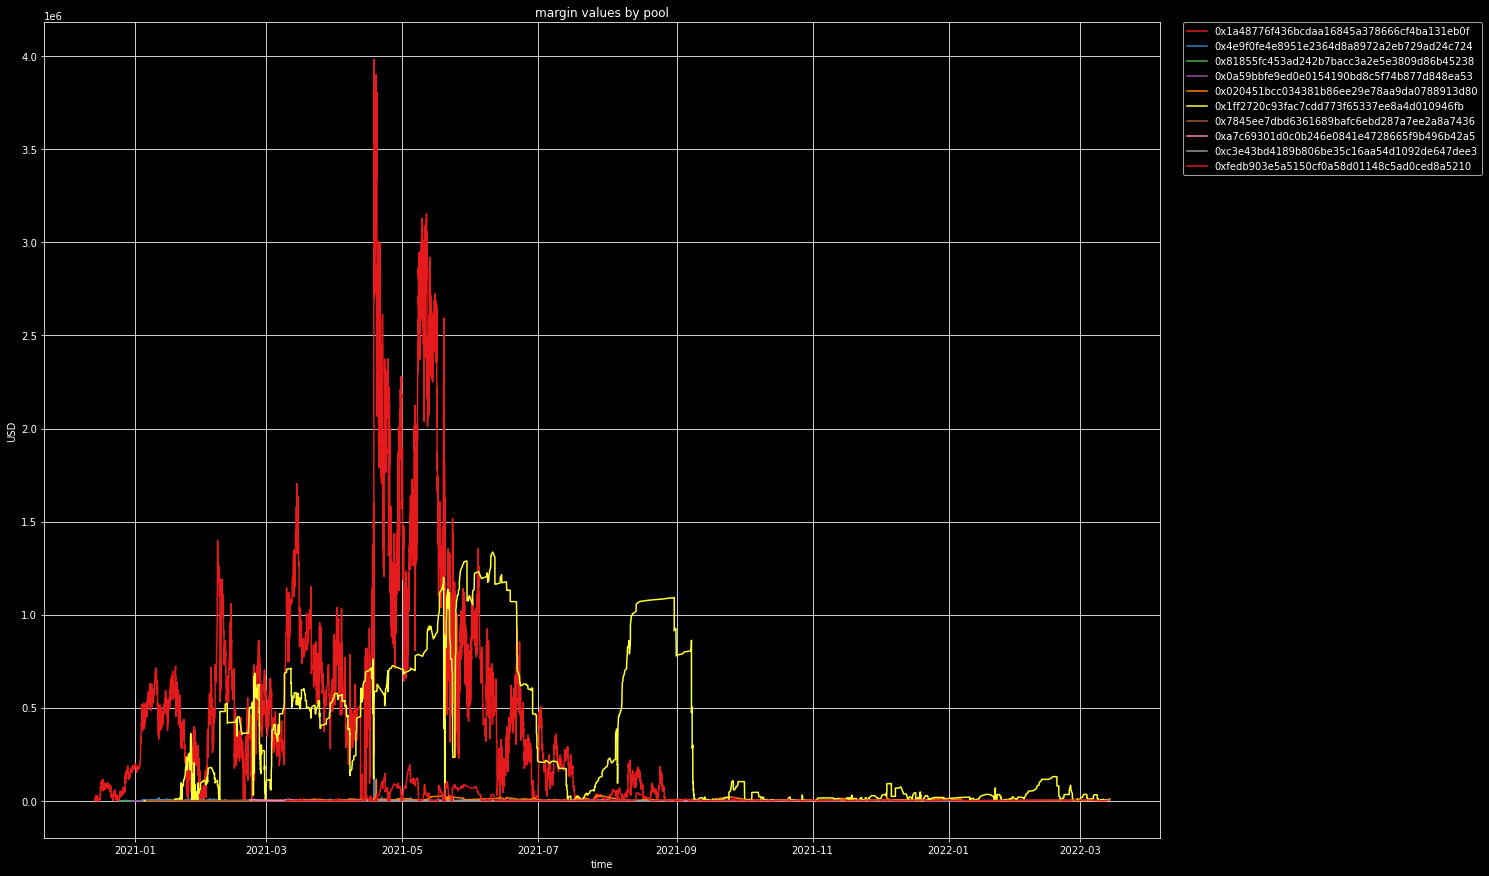

In [25]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'ETH/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[:10],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

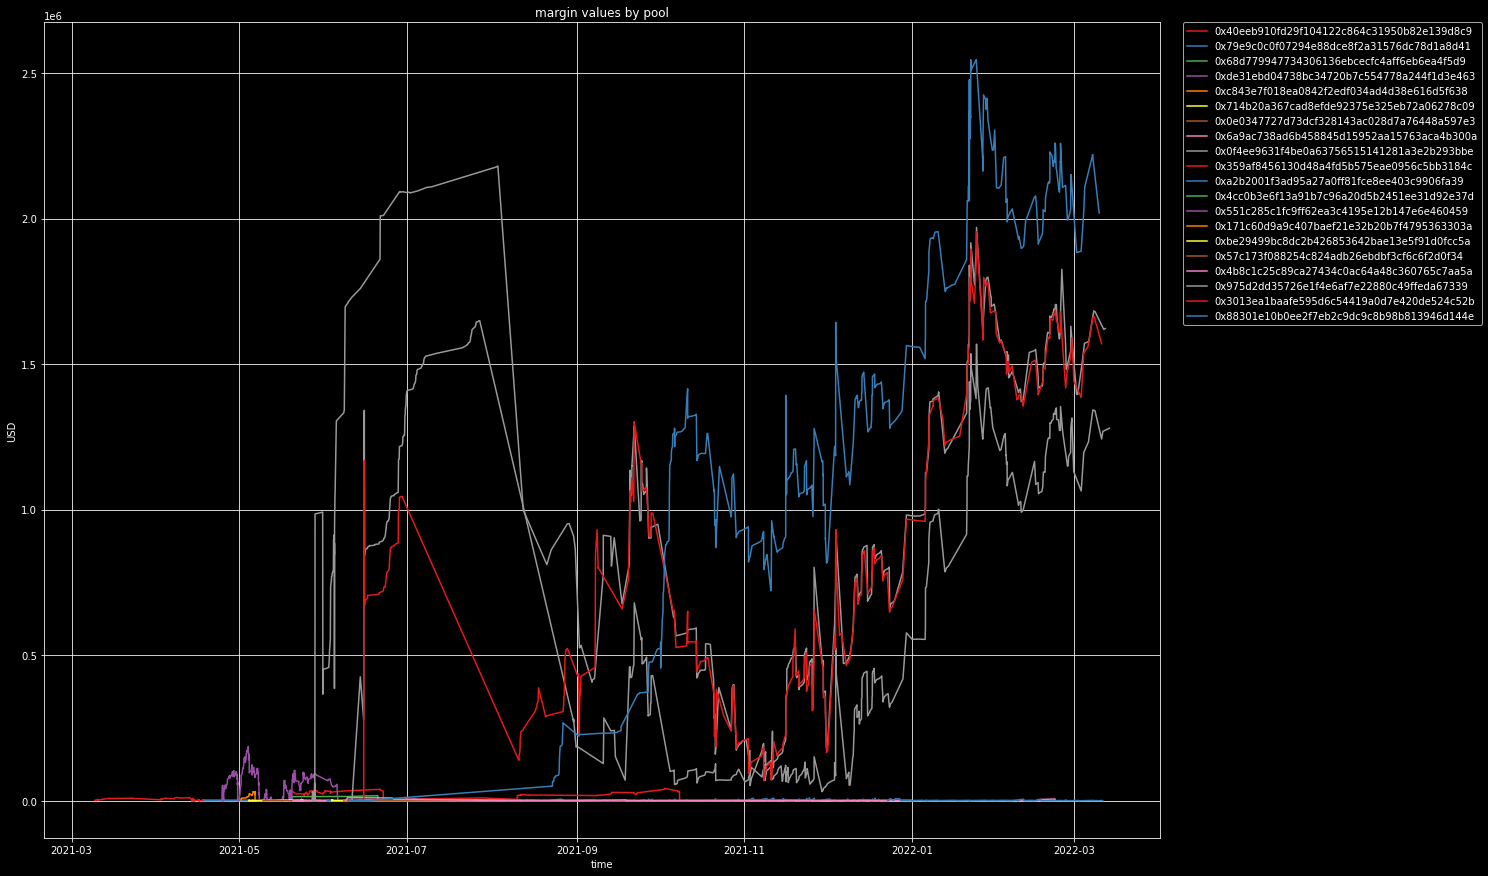

In [26]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'ETH/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[10:30],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

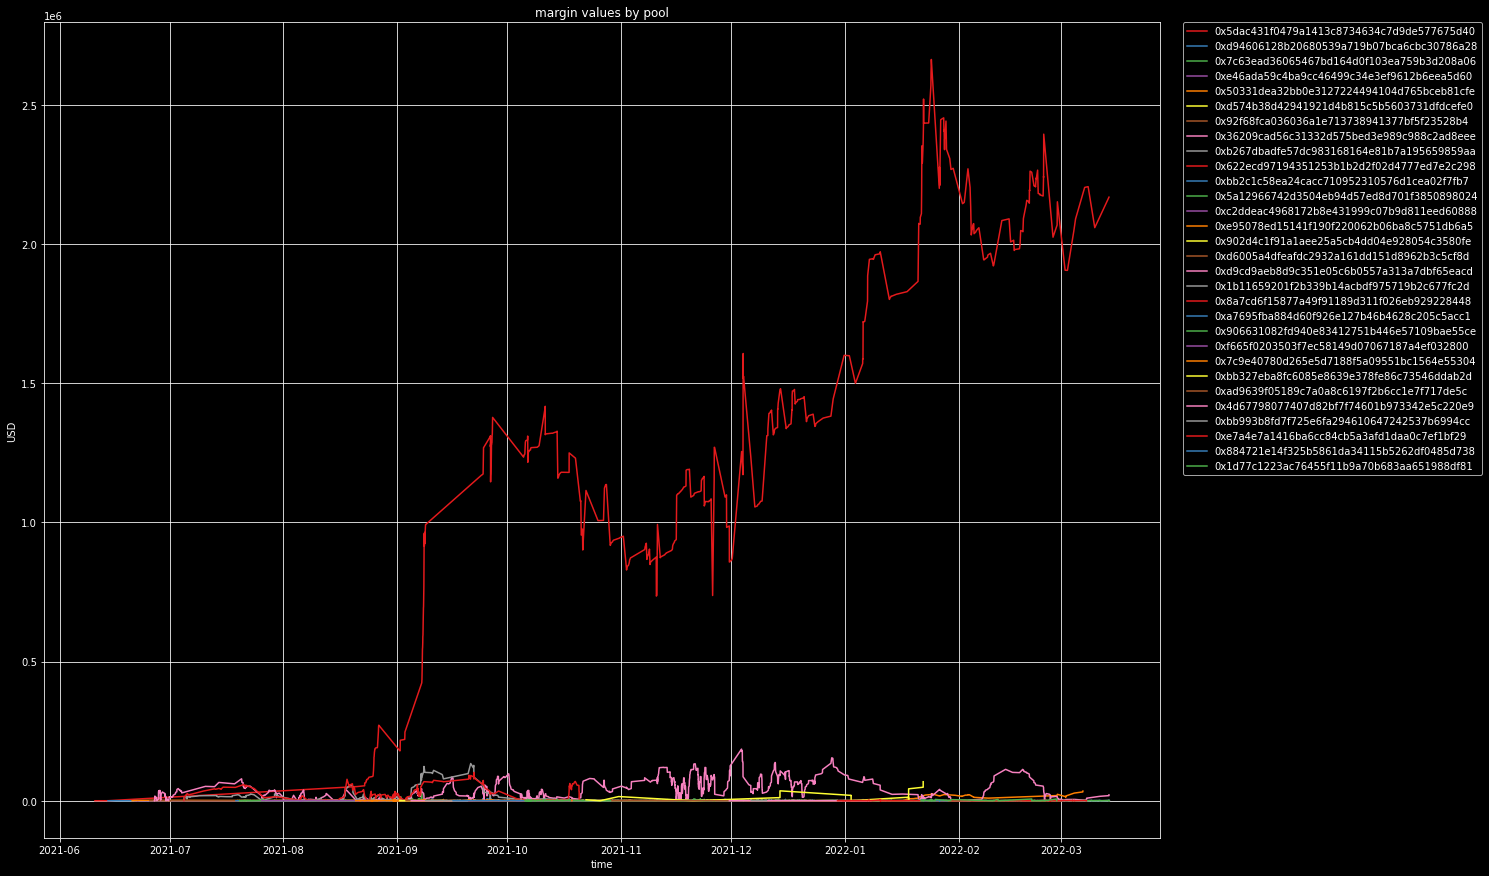

In [27]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'ETH/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[30:60],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

## Margin for PERP/USDC

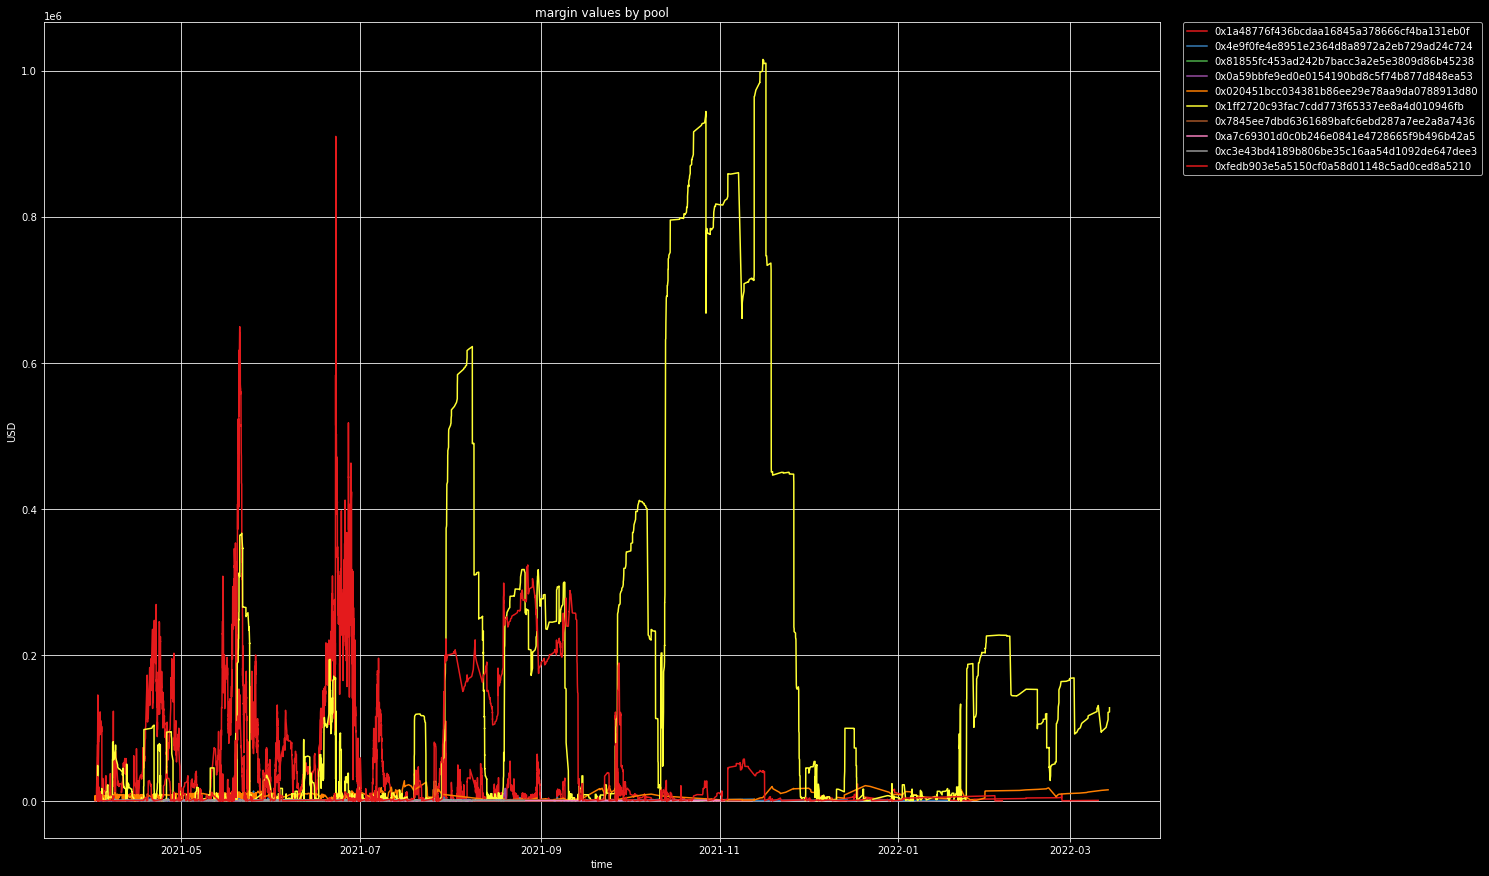

In [28]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'PERP/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[:10],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

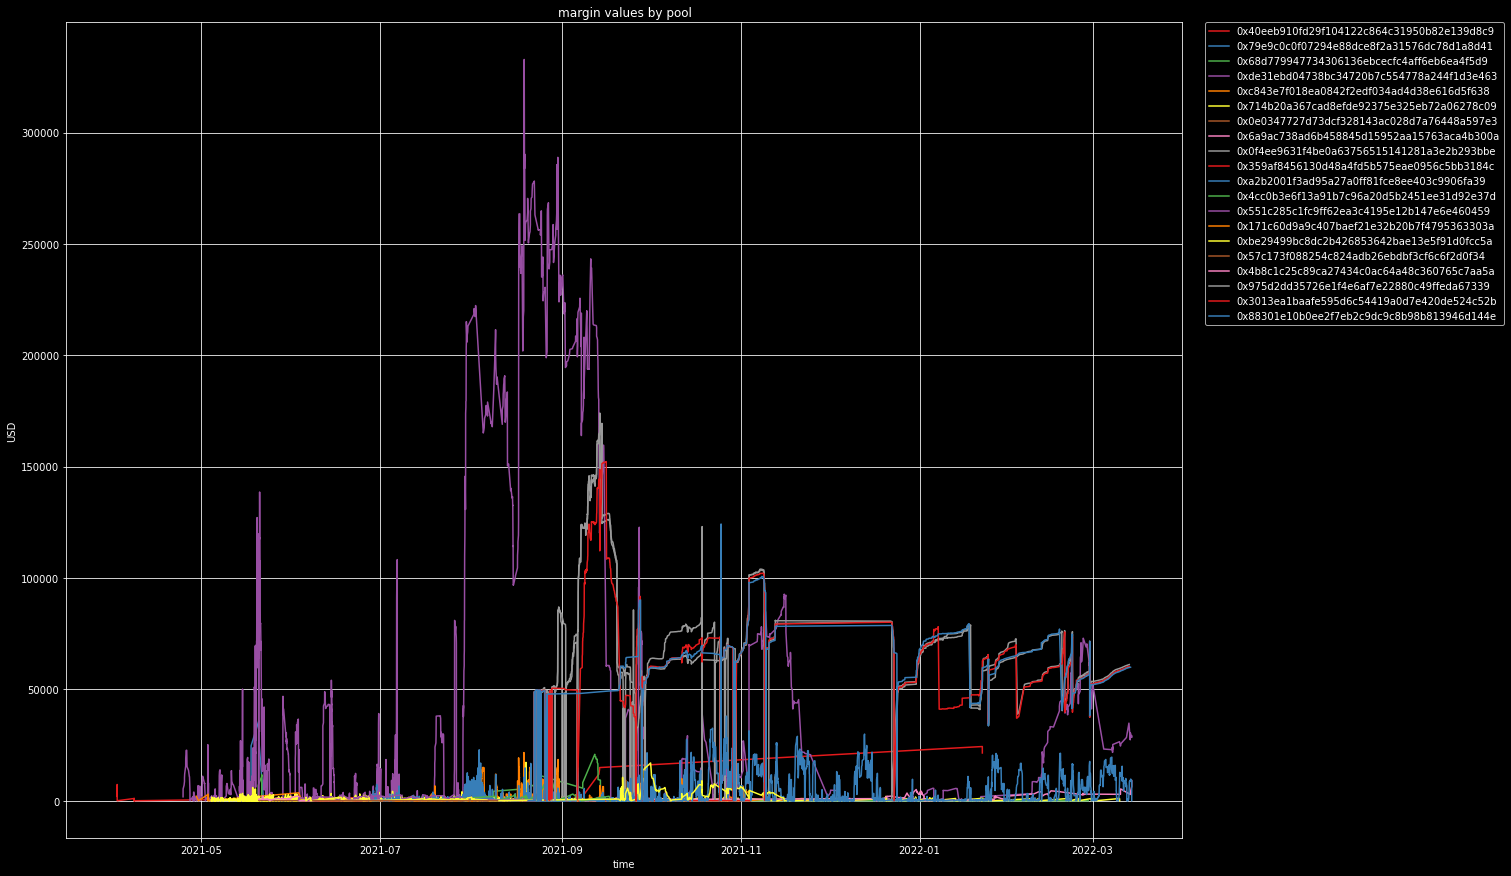

In [29]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'PERP/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[10:30],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

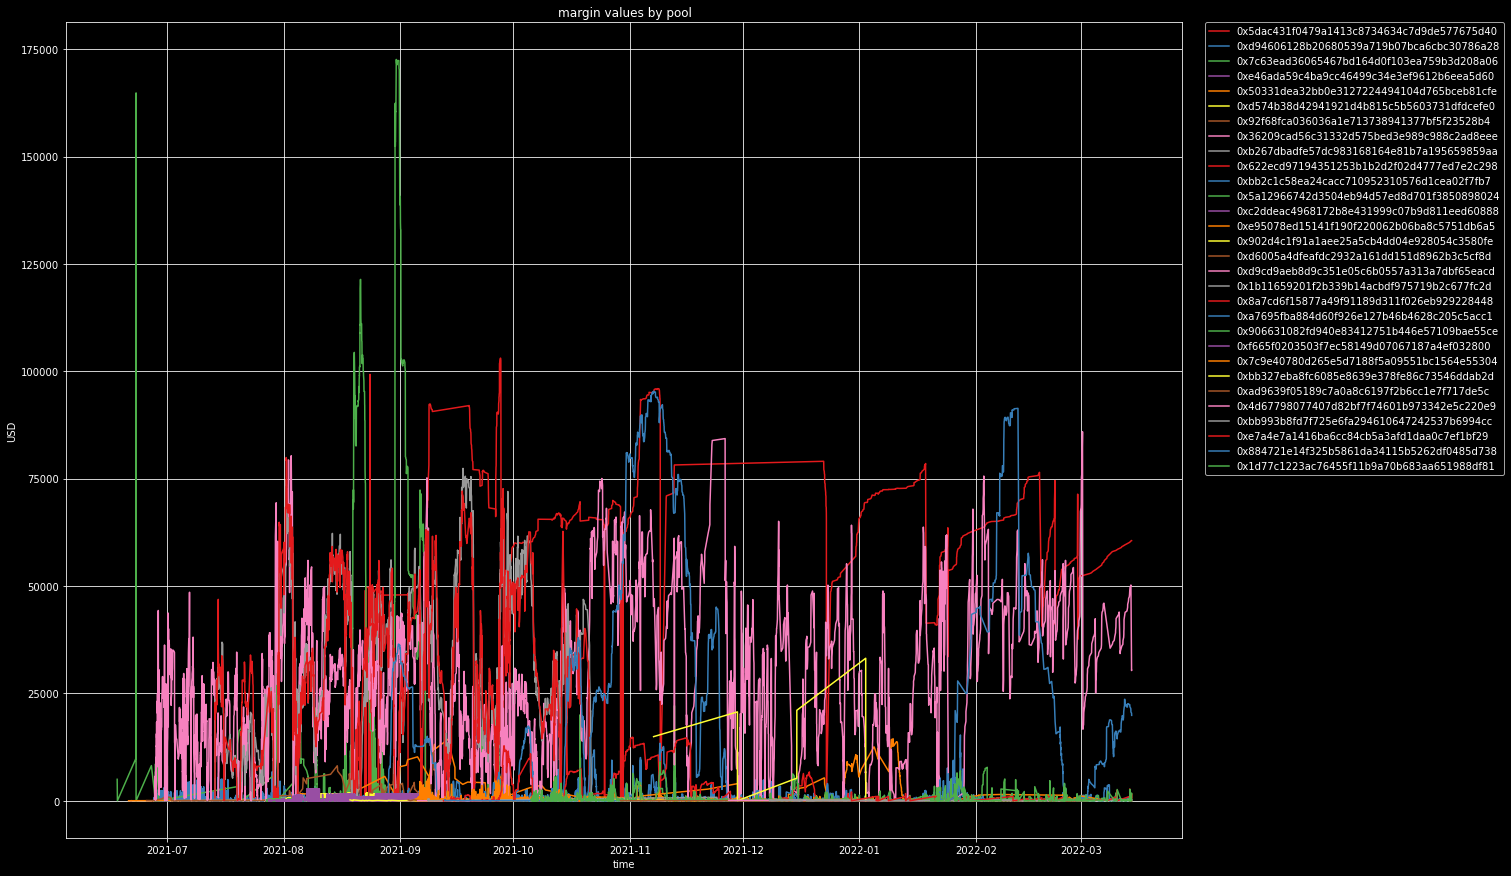

In [30]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'PERP/USDC'], 
              'timestamp', 'margin', 'trader', bots_positions_df['trader'].unique()[30:60],
              xlabel='time', ylabel='USD', title='margin values by pool', xsize=20, ysize=15, 
              is_grid_required=True)

## PnL for BTC/USDC

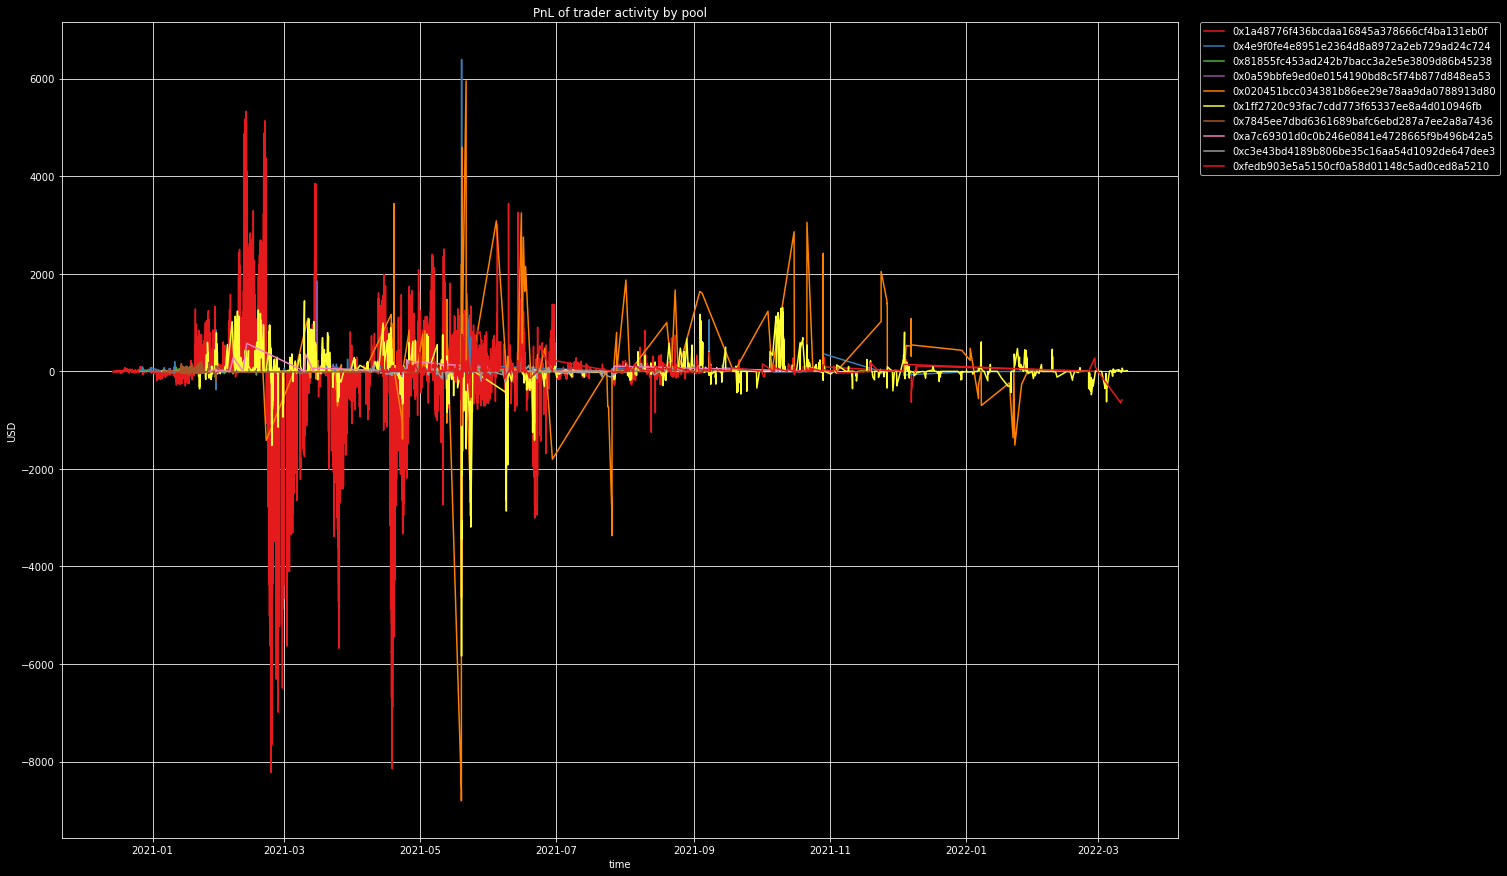

In [31]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[:10],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

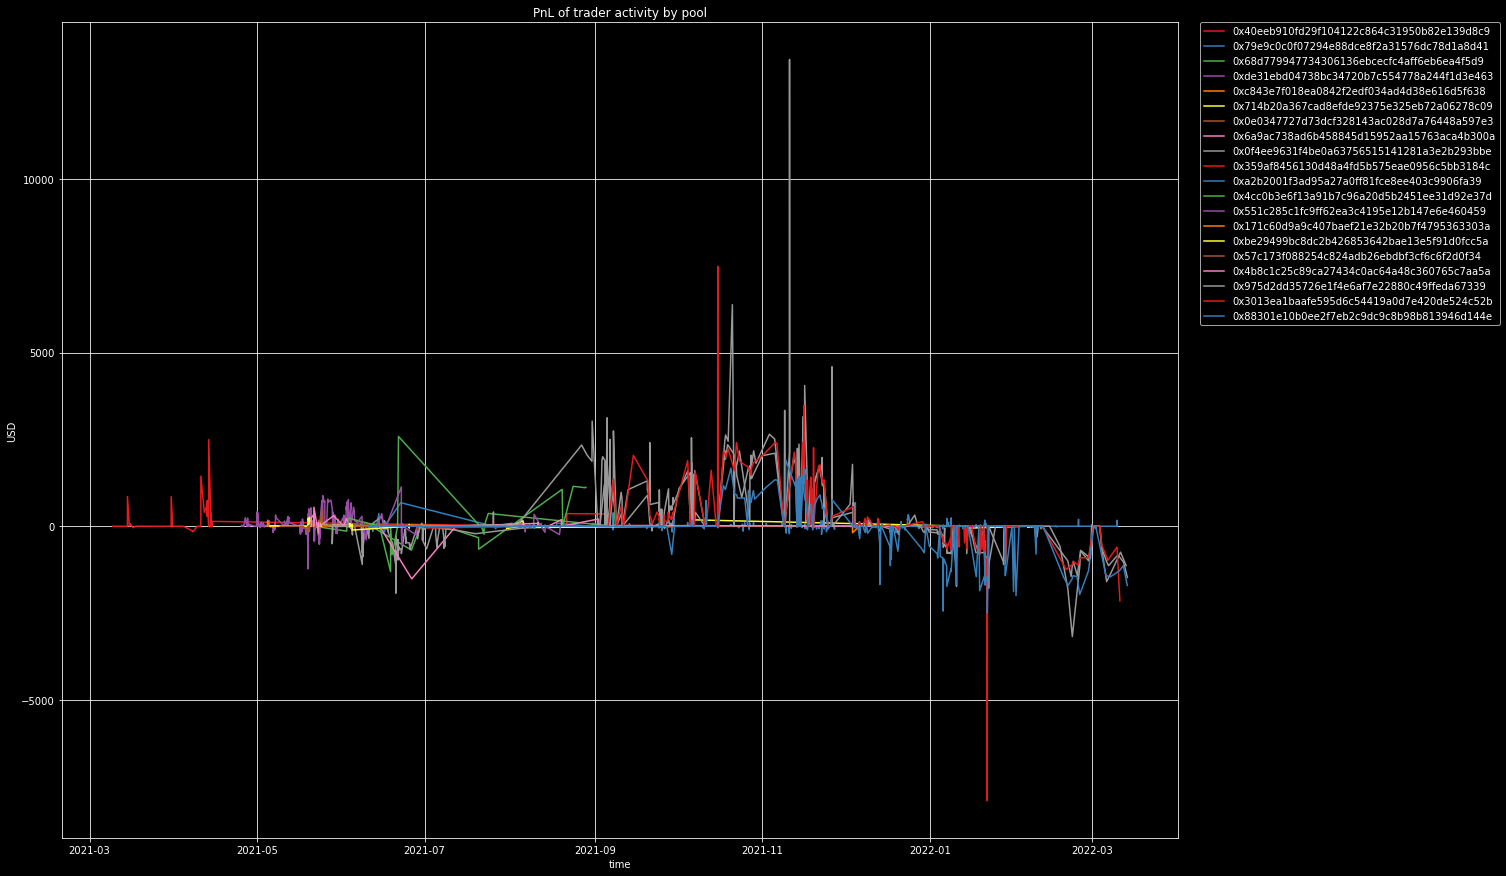

In [32]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[10:30],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

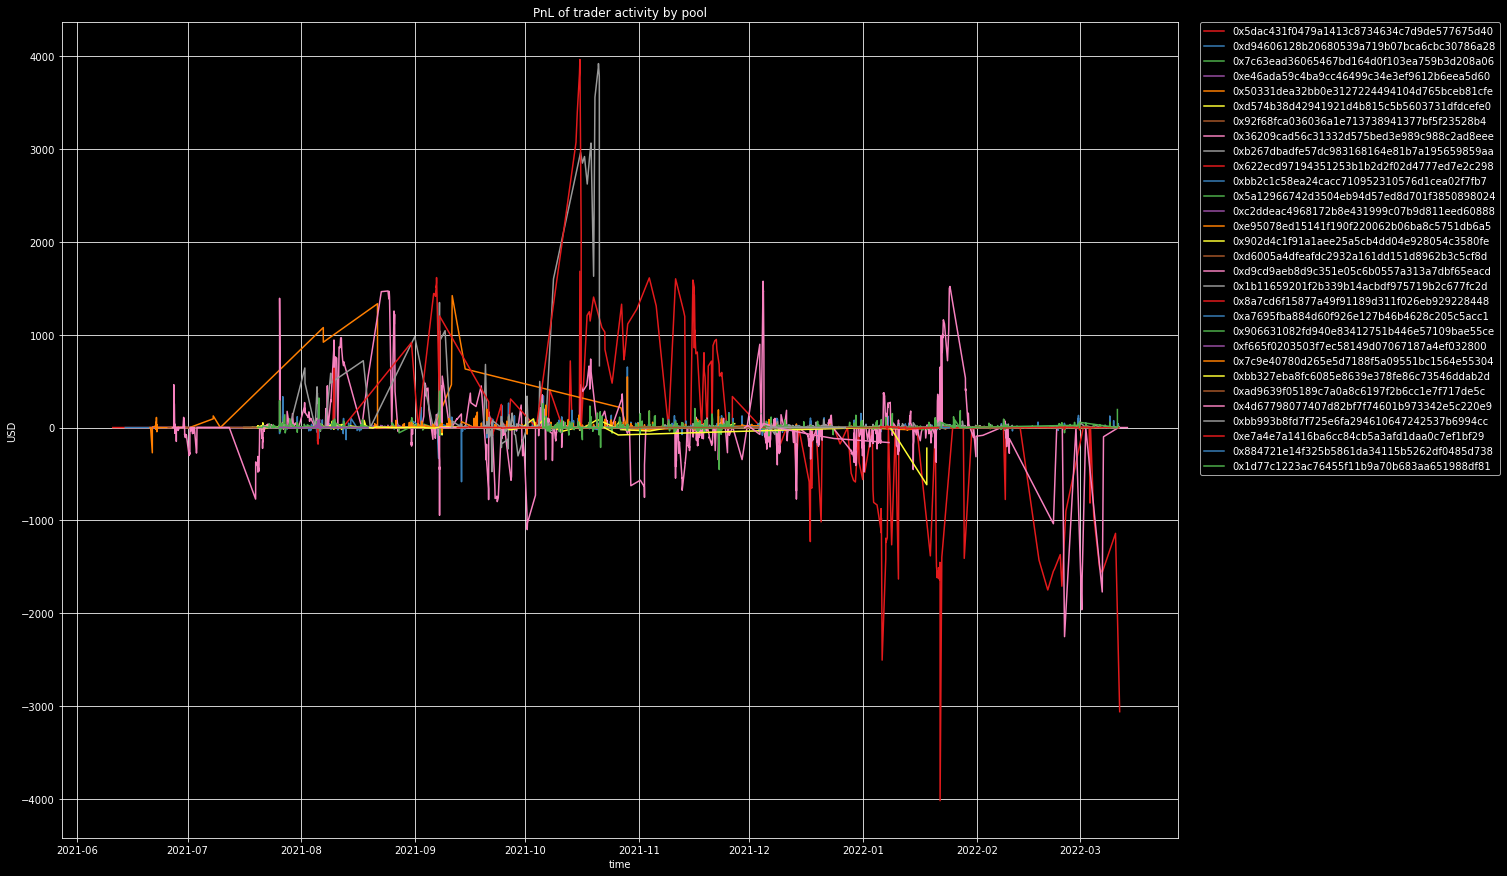

In [33]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[30:60],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

## PnL for ETH/USDC

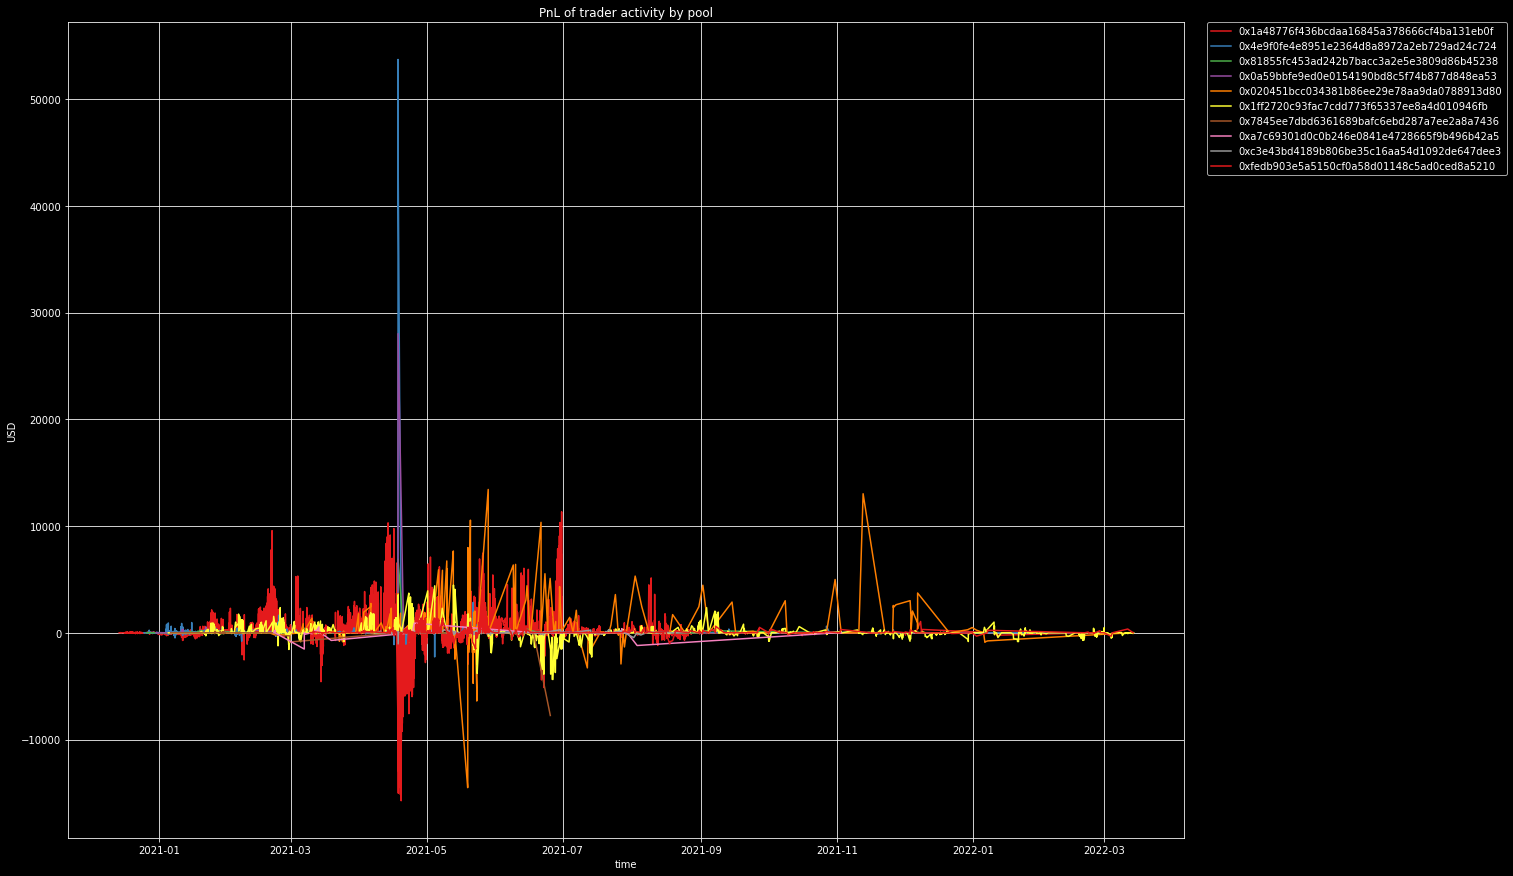

In [34]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'ETH/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[:10],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

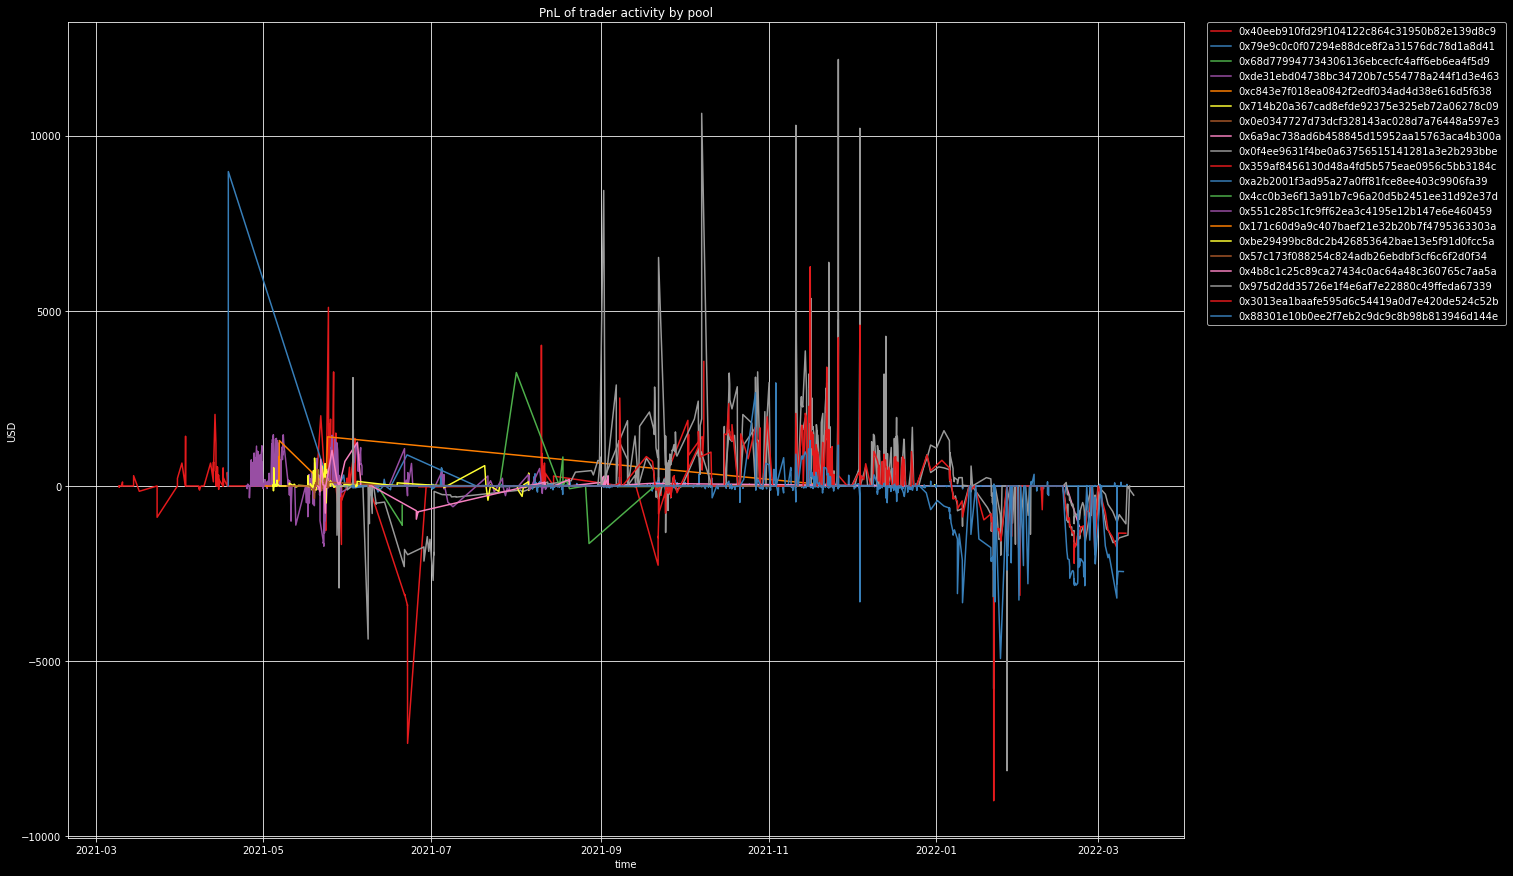

In [35]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'ETH/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[10:30],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

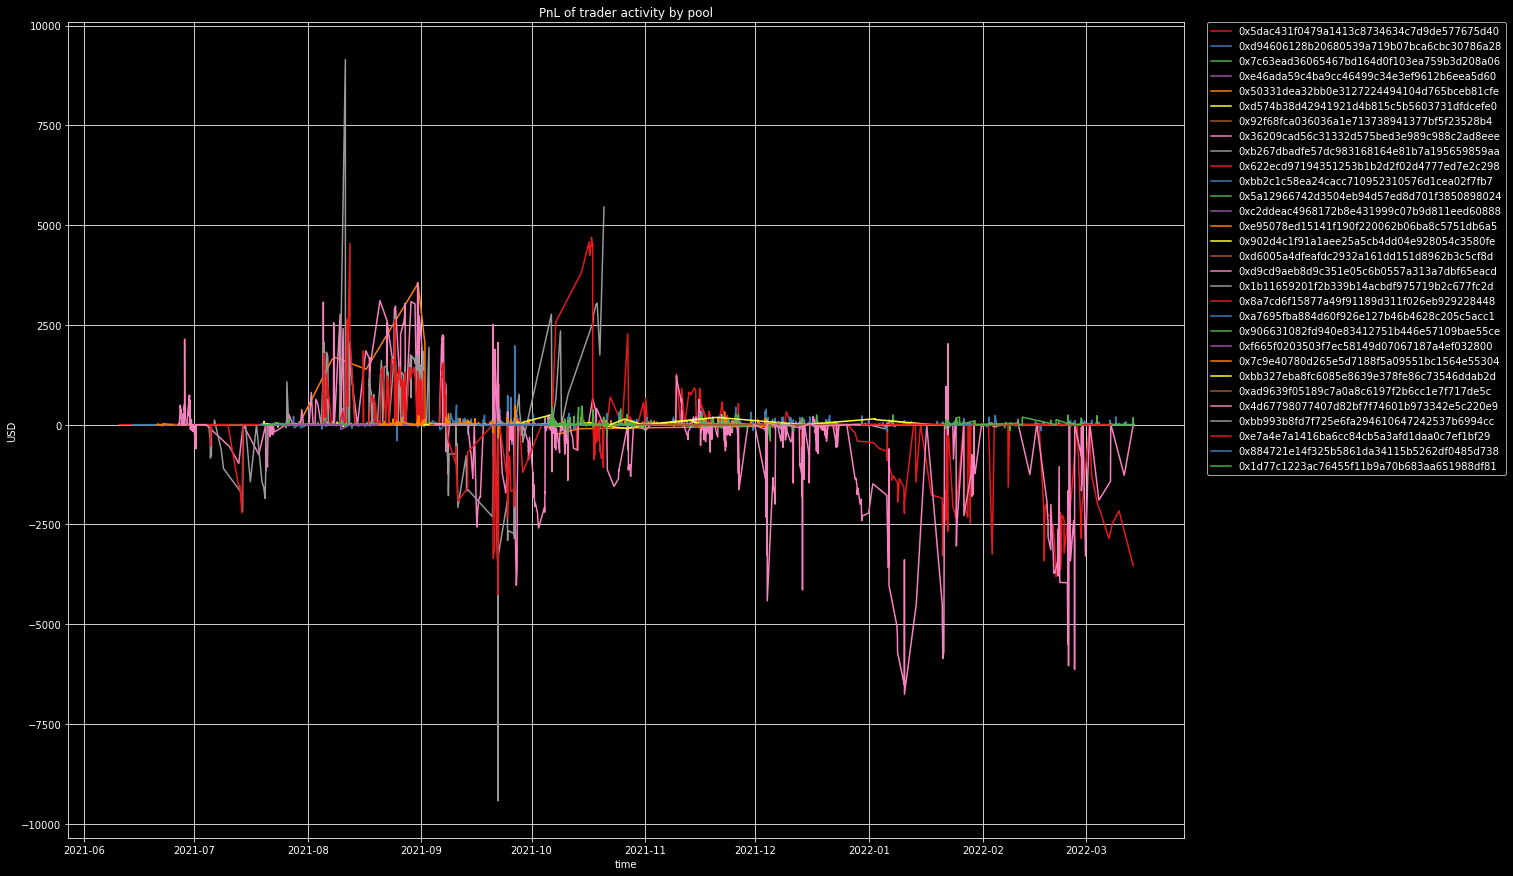

In [36]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'ETH/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[30:60],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

## PnL for PERP/USDC

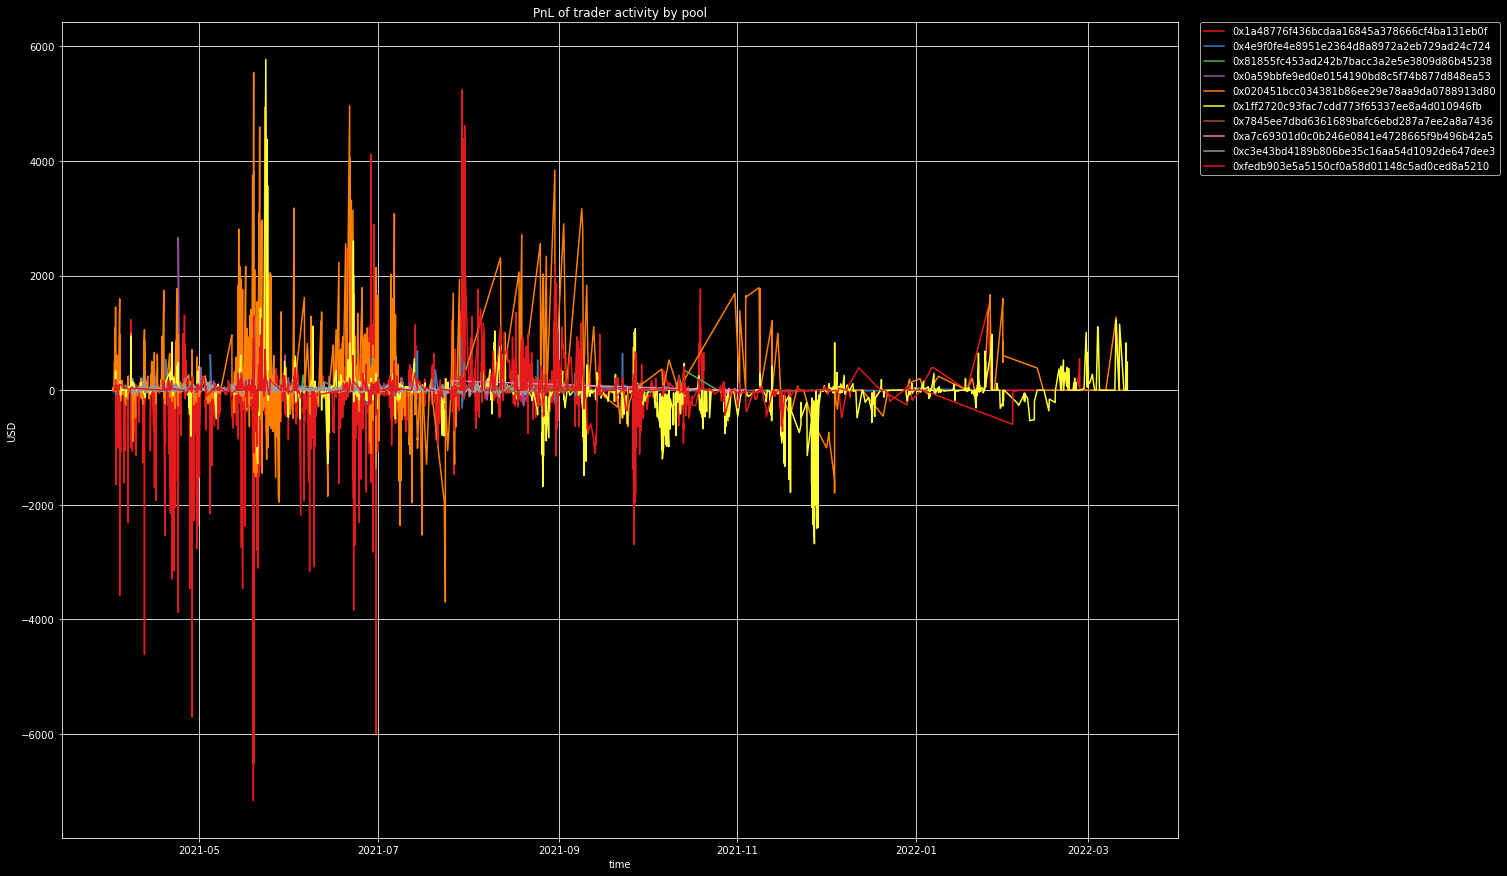

In [37]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'PERP/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[:10],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

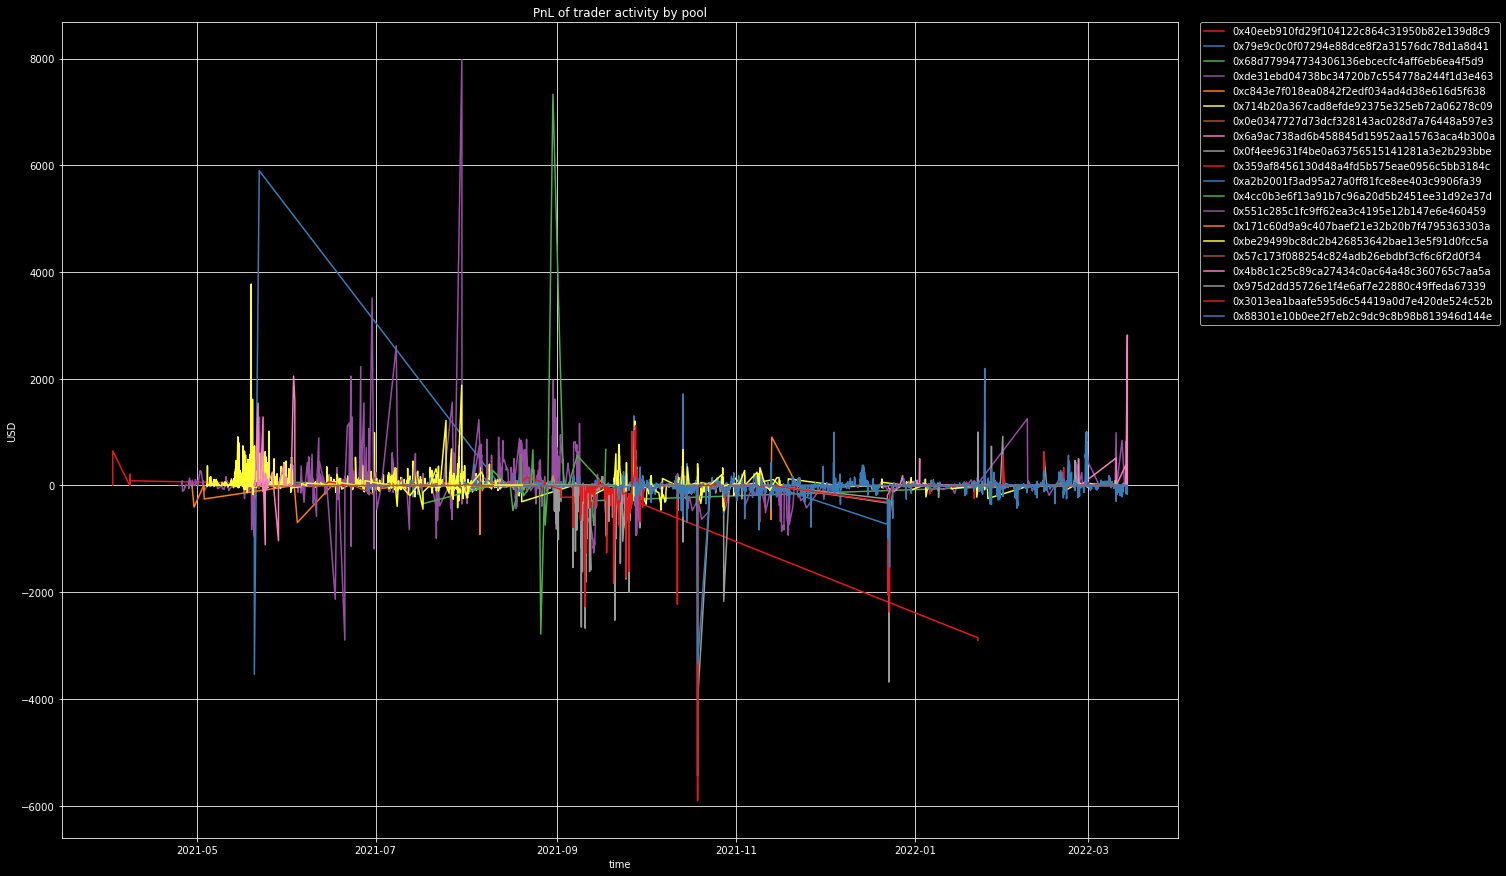

In [38]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'PERP/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[10:30],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

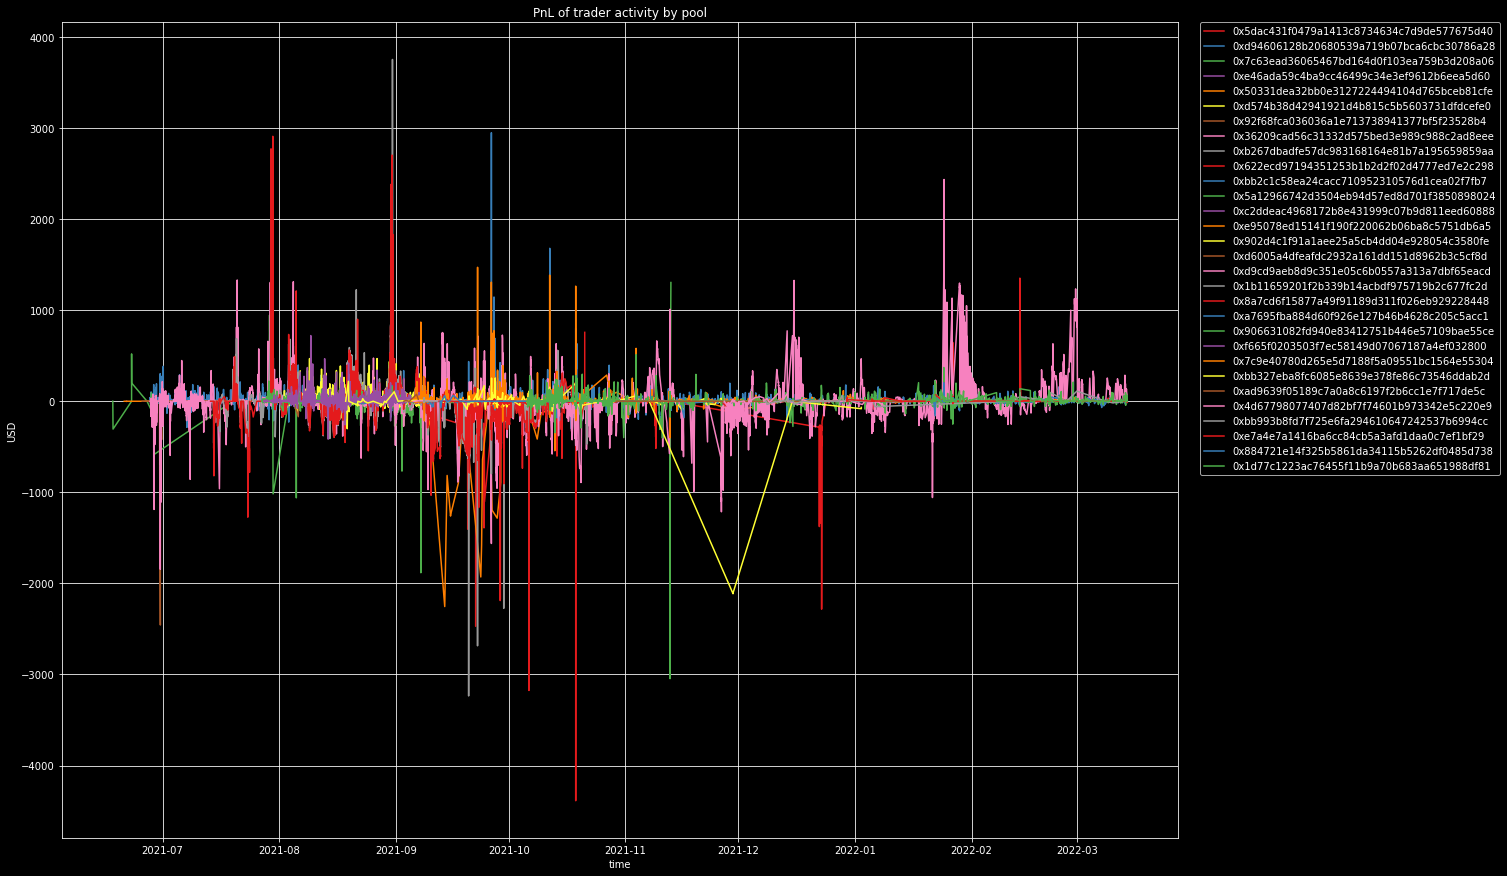

In [39]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'PERP/USDC'], 
              'timestamp', 'realized_pnl', 'trader', bots_positions_df['trader'].unique()[30:60],
              xlabel='time', ylabel='USD', title='PnL of trader activity by pool', xsize=20, ysize=15, 
              is_grid_required=True)

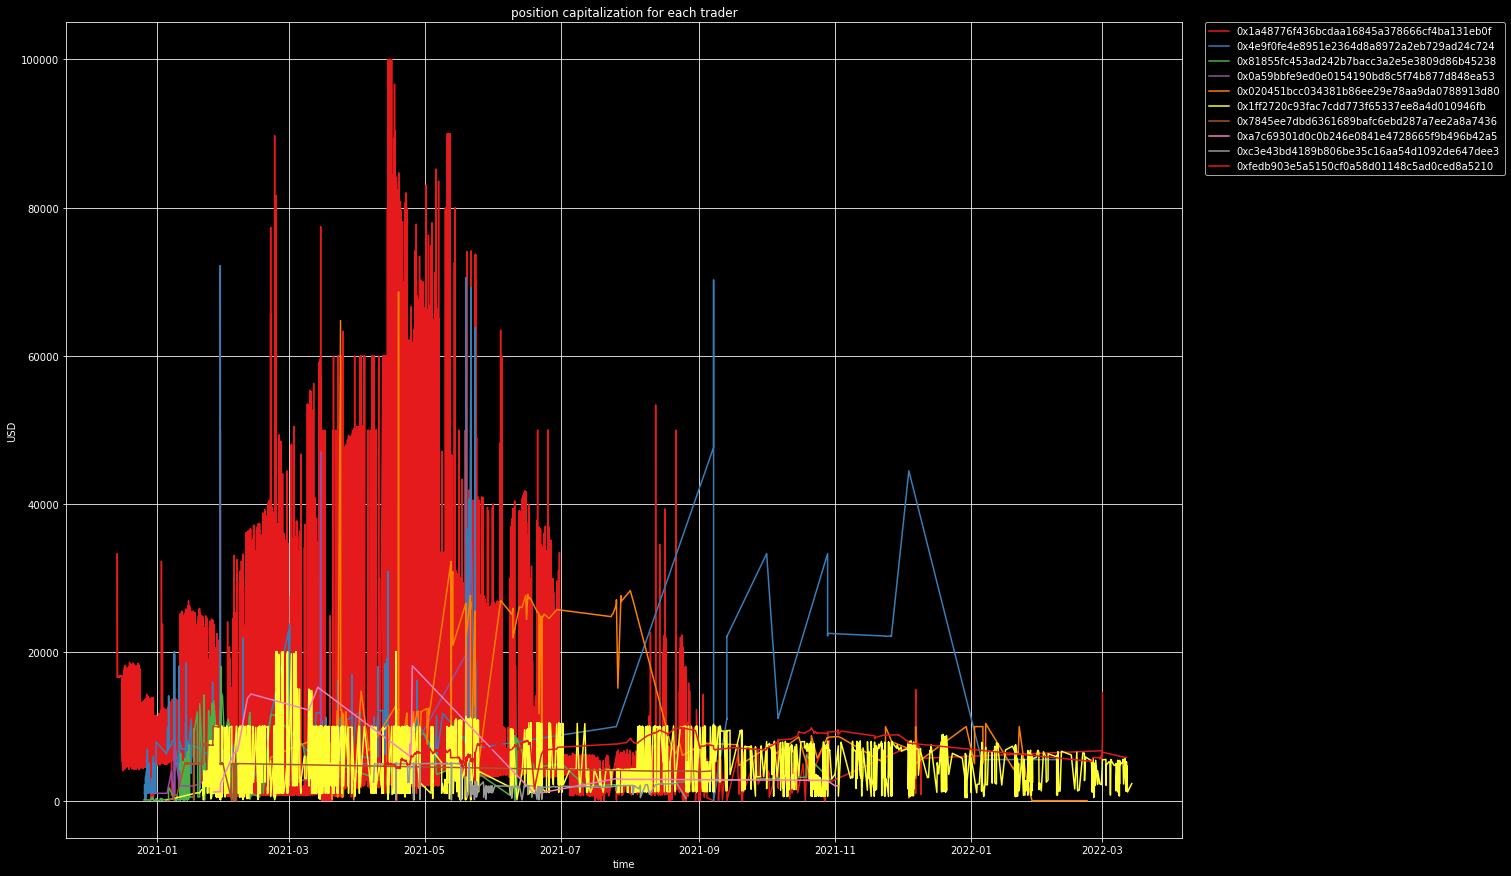

In [40]:
hued_lineplot(bots_positions_df[bots_positions_df["amm_name"] == 'BTC/USDC'], 
              'timestamp', 'position_notional', 'trader', bots_positions_df['trader'].unique()[:10],
              xlabel='time', ylabel='USD', title='position capitalization for each trader', xsize=20, ysize=15, 
              is_grid_required=True)